In [1]:
from birdcall.data import *
from birdcall.metrics import *
from birdcall.ops import *

import torch
import torchvision
from torch import nn
import numpy as np
import pandas as pd
from pathlib import Path
import soundfile as sf

In [2]:
classes = pd.read_pickle('data/classes.pkl')

In [3]:
from pathlib import Path
import soundfile as sf

In [ ]:
# train_items  = []

# for directory in Path(f'data/train_resampled').iterdir():
#     ebird_code = directory.name
#     for recording in directory.iterdir():
#         train_items.append((ebird_code, recording, sf.info(recording).duration))

In [ ]:
# train_items[:5]

In [ ]:
# from sklearn.model_selection import StratifiedKFold

# sk = StratifiedKFold()
# splits = list(sk.split([item[0] for item in train_items], [item[0] for item in train_items]))

In [ ]:
# pd.to_pickle(splits, 'data/all_splits.pkl')
# pd.to_pickle(train_items, 'data/all_train_items.pkl')

In [4]:
splits = pd.read_pickle('data/all_splits.pkl')
all_train_items = pd.read_pickle('data/all_train_items.pkl')

train_items = np.array(all_train_items)[splits[0][0]].tolist()
val_items = np.array(all_train_items)[splits[0][1]].tolist()

In [5]:
from collections import defaultdict

class2train_items = defaultdict(list)

for cls_name, path, duration in train_items:
    class2train_items[cls_name].append((path, duration))

In [6]:
train_ds = MelspecPoolDataset(class2train_items, classes, len_mult=50, normalize=False)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, num_workers=NUM_WORKERS, pin_memory=True, shuffle=True)

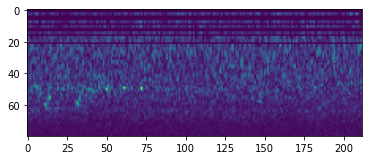

In [7]:
train_ds.show(0)

In [8]:
val_items = [(classes.index(item[0]), item[1], item[2]) for item in val_items]
val_items_binned = bin_items_negative_class(val_items)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(*list(torchvision.models.resnet34(True).children())[:-2])
        self.classifier = nn.Sequential(*[
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(p=0.5), nn.BatchNorm1d(512),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(p=0.5), nn.BatchNorm1d(512),
            nn.Linear(512, len(classes))
        ])
    
    def forward(self, x):
#         max_per_example = x.view(x.shape[0], -1).max(1)[0] # scaling to between 0 and 1
#         x / max_per_example[:, None, None, None, None]     # per example!
        bs, im_num = x.shape[:2]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4])
        x = self.cnn(x)
        x = x.mean((2,3))
        x = self.classifier(x)
        x = x.view(bs, im_num, -1)
        x = lme_pool(x)
        return x

In [10]:
model = Model().cuda()

In [11]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import time

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), 1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)

In [17]:
t0 = time.time()
for epoch in range(130):
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        model.train()
        inputs, labels = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if np.isnan(loss.item()): 
            print(f'!!! nan encountered in loss !!! alpha: epoch: {epoch}\n')
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()


    if epoch % 5 == 4:
        model.eval();
        preds = []
        targs = []

        for num_specs in val_items_binned.keys():
            valid_ds = MelspecShortishValidatioDataset(val_items_binned[num_specs], classes)
            valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=2*16, num_workers=NUM_WORKERS, pin_memory=True)

            with torch.no_grad():
                for data in valid_dl:
                    inputs, labels = data[0].cuda(), data[1].cuda()
                    outputs = model(inputs)
                    preds.append(outputs.cpu().detach())
                    targs.append(labels.cpu().detach())

        preds = torch.cat(preds)
        targs = torch.cat(targs)

        accuracy = accuracy_score(preds.sigmoid() > 0.5, targs)
        f1 = f1_score(preds.sigmoid() > 0.5, targs, average='micro')
        print(f'[{epoch + 1}, {(time.time() - t0)/60:.1f}] loss: {running_loss / (len(train_dl)-1):.3f}, acc: {accuracy:.3f}, f1: {f1:.3f}')
        running_loss = 0.0

        torch.save(model.state_dict(), f'models/{epoch+1}_lmepool_simple_{round(f1, 2)}.pth')

[5, 17.3] loss: 0.023, acc: 0.000, f1: 0.000
[10, 37.3] loss: 0.021, acc: 0.001, f1: 0.002
[15, 56.4] loss: 0.018, acc: 0.008, f1: 0.019
[20, 75.5] loss: 0.016, acc: 0.051, f1: 0.100
[25, 94.9] loss: 0.015, acc: 0.142, f1: 0.253
[30, 114.6] loss: 0.013, acc: 0.208, f1: 0.345
[35, 134.4] loss: 0.011, acc: 0.284, f1: 0.439
[40, 154.6] loss: 0.010, acc: 0.339, f1: 0.496
[45, 174.0] loss: 0.009, acc: 0.388, f1: 0.552
[50, 194.3] loss: 0.008, acc: 0.434, f1: 0.591
[55, 213.7] loss: 0.007, acc: 0.447, f1: 0.598
[60, 232.4] loss: 0.007, acc: 0.473, f1: 0.627
[65, 251.5] loss: 0.006, acc: 0.506, f1: 0.650
[70, 271.2] loss: 0.006, acc: 0.501, f1: 0.648
[75, 290.1] loss: 0.005, acc: 0.402, f1: 0.559
[80, 309.9] loss: 0.005, acc: 0.542, f1: 0.680
[85, 329.4] loss: 0.004, acc: 0.520, f1: 0.667
[90, 348.8] loss: 0.004, acc: 0.532, f1: 0.674
[95, 369.4] loss: 0.004, acc: 0.541, f1: 0.677
[100, 389.3] loss: 0.003, acc: 0.540, f1: 0.675
[105, 408.8] loss: 0.003, acc: 0.541, f1: 0.684
[110, 428.4] loss

In [18]:
f1s = []
ts = []
for t in np.linspace(0.4, 1, 61):
    f1s.append(f1_score(preds.sigmoid() > t, targs, average='micro'))
    ts.append(t)

In [19]:
max(f1s), accuracy_score(preds.sigmoid() > ts[np.argmax(f1s)], targs)

(0.6974032856385798, 0.5616374269005848)

In [20]:
ts[np.argmax(f1s)]

0.61

In [21]:
from birdcall.metrics import *

preds_to_tp_fp_fn(preds, targs)

(tensor(2620), tensor(627), tensor(1655))

In [22]:
t0 = time.time()
for epoch in range(130, 260):
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        model.train()
        inputs, labels = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if np.isnan(loss.item()): 
            print(f'!!! nan encountered in loss !!! alpha: epoch: {epoch}\n')
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()


    if epoch % 5 == 4:
        model.eval();
        preds = []
        targs = []

        for num_specs in val_items_binned.keys():
            valid_ds = MelspecShortishValidatioDataset(val_items_binned[num_specs], classes)
            valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=2*16, num_workers=NUM_WORKERS, pin_memory=True)

            with torch.no_grad():
                for data in valid_dl:
                    inputs, labels = data[0].cuda(), data[1].cuda()
                    outputs = model(inputs)
                    preds.append(outputs.cpu().detach())
                    targs.append(labels.cpu().detach())

        preds = torch.cat(preds)
        targs = torch.cat(targs)

        accuracy = accuracy_score(preds.sigmoid() > 0.5, targs)
        f1 = f1_score(preds.sigmoid() > 0.5, targs, average='micro')
        print(f'[{epoch + 1}, {(time.time() - t0)/60:.1f}] loss: {running_loss / (len(train_dl)-1):.3f}, acc: {accuracy:.3f}, f1: {f1:.3f}')
        running_loss = 0.0

        torch.save(model.state_dict(), f'models/{epoch+1}_lmepool_simple_{round(f1, 2)}.pth')

[135, 19.4] loss: 0.002, acc: 0.552, f1: 0.687
[140, 38.3] loss: 0.002, acc: 0.546, f1: 0.684
[145, 58.4] loss: 0.002, acc: 0.563, f1: 0.699
[150, 77.2] loss: 0.002, acc: 0.511, f1: 0.652
[155, 96.7] loss: 0.002, acc: 0.531, f1: 0.678
[160, 116.4] loss: 0.002, acc: 0.564, f1: 0.702
[165, 136.6] loss: 0.002, acc: 0.572, f1: 0.706
[170, 155.8] loss: 0.002, acc: 0.550, f1: 0.688
[175, 175.3] loss: 0.002, acc: 0.564, f1: 0.703
[180, 194.2] loss: 0.002, acc: 0.563, f1: 0.698
[185, 214.2] loss: 0.002, acc: 0.565, f1: 0.699
[190, 233.0] loss: 0.002, acc: 0.571, f1: 0.704
[195, 252.9] loss: 0.001, acc: 0.576, f1: 0.705
[200, 272.6] loss: 0.001, acc: 0.564, f1: 0.701
[205, 291.5] loss: 0.001, acc: 0.570, f1: 0.704
[210, 311.2] loss: 0.001, acc: 0.567, f1: 0.702
[215, 330.9] loss: 0.001, acc: 0.561, f1: 0.699
[220, 349.9] loss: 0.001, acc: 0.572, f1: 0.709
[225, 369.9] loss: 0.001, acc: 0.547, f1: 0.686
[230, 390.1] loss: 0.001, acc: 0.568, f1: 0.703
[235, 409.4] loss: 0.001, acc: 0.559, f1: 0.6

In [23]:
f1s = []
ts = []
for t in np.linspace(0.4, 1, 61):
    f1s.append(f1_score(preds.sigmoid() > t, targs, average='micro'))
    ts.append(t)

In [24]:
max(f1s), accuracy_score(preds.sigmoid() > ts[np.argmax(f1s)], targs)

(0.6963497793822703, 0.5595321637426901)

In [25]:
ts[np.argmax(f1s)]

0.56

In [26]:
preds_to_tp_fp_fn(preds, targs)

(tensor(2571), tensor(544), tensor(1704))

In [39]:
model.load_state_dict(torch.load('models/195_lmepool_simple_0.71.pth'))

<All keys matched successfully>

In [40]:
model.eval();
preds = []
targs = []

for num_specs in [1]:#val_items_binned.keys():
    valid_ds = MelspecShortishValidatioDataset(val_items_binned[num_specs], classes)
    valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=2*16, num_workers=NUM_WORKERS, pin_memory=True)

    with torch.no_grad():
        for data in valid_dl:
            inputs, labels = data[0].cuda(), data[1].cuda()
            outputs = model(inputs)
            preds.append(outputs.cpu().detach())
            targs.append(labels.cpu().detach())

preds = torch.cat(preds)
targs = torch.cat(targs)

accuracy = accuracy_score(preds.sigmoid() > 0.5, targs)
f1 = f1_score(preds.sigmoid() > 0.5, targs, average='micro')

f1s = []
ts = []
for t in np.linspace(0.4, 1, 61):
    f1s.append(f1_score(preds.sigmoid() > t, targs, average='micro'))
    ts.append(t)

accuracy, f1, accuracy_score(preds.sigmoid() > ts[np.argmax(f1s)], targs), max(f1s), ts[np.argmax(f1s)]

(0.42488262910798125,
 0.5625965996908809,
 0.44366197183098594,
 0.5735735735735735,
 0.41000000000000003)

In [42]:
from IPython.lib.display import FileLink

In [43]:
FileLink('models/195_lmepool_simple_0.71.pth')

/home/radek/workspace/birdcall/models/195_lmepool_simple_0.71.pth